In [1]:
import time
import warnings
import itertools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
# import pydotplus
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.externals.six import StringIO
from sklearn import tree

import pickle

In [2]:
#import cleaned traning and testing sets
df = pd.read_csv('training_set_clean.csv')
df_test = pd.read_csv('test_set_values_clean.csv')

In [3]:
df.shape, df_test.shape

((59400, 72), (14850, 71))

In [4]:
#the different column is the label or status_group column
df.columns.difference(df_test.columns)

Index(['status_group'], dtype='object')

# Build Classifier

In [5]:
#Separate training set into features and labels 
X = df.drop(columns = ['id', 'status_group']).values
y = df['status_group'].values

In [6]:
# normalize data
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))

In [7]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

In [8]:
print('Training set: ', X_train.shape, y_train.shape)
print('Testing set: ', X_test.shape, y_test.shape)

Training set:  (44550, 70) (44550,)
Testing set:  (14850, 70) (14850,)


In [9]:
#train model
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=5).fit(X_train, y_train)
dtc

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [10]:
# predict
y_hat = dtc.predict(X_test)

In [11]:
# get accuracy of model

print('Train set Accuracy: ', metrics.accuracy_score(y_train, dtc.predict(X_train)))
print('Test set Accuracy: ', metrics.accuracy_score(y_test, y_hat))

Train set Accuracy:  0.7134006734006734
Test set Accuracy:  0.7104377104377104


# Confusion matrix

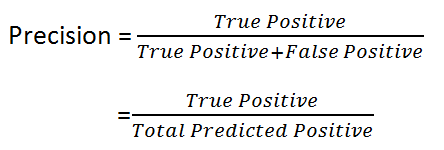

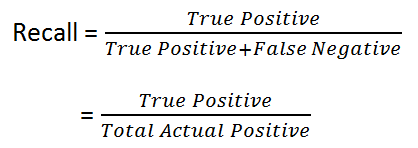

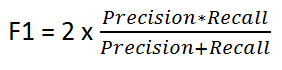

In [12]:
# Create a confusion matrix for K=1 model.
print(classification_report(y_test, y_hat))
pd.DataFrame(confusion_matrix(y_test, y_hat), columns=['Pred Func', 'Pred Needs Fix', 'Pred Non Func'], index=['Act Func', 'Act Needs Fix', 'Act Non Func'])

                         precision    recall  f1-score   support

             functional       0.67      0.95      0.79      8008
functional needs repair       0.44      0.07      0.12      1062
         non functional       0.86      0.50      0.63      5780

            avg / total       0.73      0.71      0.68     14850



,Pred Func,Pred Needs Fix,Pred Non Func
Act Func,7594,40,374
Act Needs Fix,886,74,102
Act Non Func,2844,54,2882


### This model is more likely to predict that pumps will be functional. It has a great recall (0.95) for functional pumps, which means it accurately predicts "functional" status when the pump is actually functional. However, it has a 0.5 recall for "non functional" status (we can see that it predicts non functional accurately about half of the time). Lastly, this model only has a 0.07 recall rate for "functional needs repair" pumps.

# Random Forest

In [13]:
#train model
rfc = RandomForestClassifier(criterion='entropy', max_depth=None).fit(X_train, y_train)

In [14]:
#predict
y_hat_RF = rfc.predict(X_test)

In [15]:
print('Train set Accuracy: ', metrics.accuracy_score(y_train, rfc.predict(X_train)))
print('Test set Accuracy: ', metrics.accuracy_score(y_test, y_hat_RF))

Train set Accuracy:  0.9806734006734007
Test set Accuracy:  0.7962289562289562


# Hyperparameter tuning - Grid Search Cross Validation

# Save/Open model using pickle

In [18]:
#save model
# pickle.dump(grid_rfc, open('grid_rfc.pkl', 'wb'))

# run model
grid_rfc = pickle.load(open('grid_rfc.pkl', 'rb'))

In [19]:
# %%time
# rfc_params = {'n_estimators':[2,5,10,20,50,75,150],
#               'criterion':['gini', 'entropy'],
#               'max_depth':[2,5,10,20,50,None],
#               'min_samples_split':[2,5,10,20]}


# grid_rfc = GridSearchCV(RandomForestClassifier(), 
#                         rfc_params, 
#                         cv=5, 
#                         scoring='accuracy').fit(X_train, y_train)

In [20]:
y_hat_GS = grid_rfc.predict(X_test)

In [21]:
print('Train set Accuracy: ', metrics.accuracy_score(y_train, grid_rfc.predict(X_train)))
print('Test set Accuracy: ', metrics.accuracy_score(y_test, y_hat_GS))

Train set Accuracy:  0.9016835016835016
Test set Accuracy:  0.813063973063973


In [22]:
# Create a confusion matrix for K=1 model.
print(classification_report(y_test, y_hat_GS))
pd.DataFrame(confusion_matrix(y_test, y_hat_GS), columns=['Pred Func', 'Pred Needs Fix', 'Pred Non Func'], index=['Act Func', 'Pred Needs Fix', 'Act Non Func'])

                         precision    recall  f1-score   support

             functional       0.80      0.90      0.85      8008
functional needs repair       0.64      0.32      0.43      1062
         non functional       0.85      0.78      0.81      5780

            avg / total       0.81      0.81      0.80     14850



,Pred Func,Pred Needs Fix,Pred Non Func
Act Func,7229,128,651
Pred Needs Fix,562,339,161
Act Non Func,1210,64,4506


### Using a grid search cross validation has improved the overall test set accuracy to 81%. The f1 score has increased for all three categories. The recall has increased for functional needs repair and non functional pumps but decreased for functional pumps.

# Run model on test data

In [23]:
X_testing_set = df_test.drop(columns = ['id']).values

In [24]:
y_hat_testing_set = grid_rfc.predict(X_testing_set)

In [25]:
preds = pd.DataFrame(y_hat_testing_set)

In [26]:
prediction_testing_set = pd.concat((df_test['id'], preds), axis=1)
prediction_testing_set

,id,0
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,functional
4,49871,functional
...,...,...
14845,39307,functional
14846,18990,functional
14847,28749,functional
14848,33492,functional


In [27]:
prediction_testing_set.to_csv('predictions_testing_set.csv', index=False)